In [1]:
!pip install bruges
!pip install segyio
!pip install obspy

     |████████████████████████████████| 61kB 3.7MB/s 
  Created wheel for bruges: filename=bruges-0.3.4-cp36-none-any.whl size=65219 sha256=1bb6210c81efca79495f70beb18d2afb1f3416dfa5ecc6b1b487500b5a2958ca
  Stored in directory: /root/.cache/pip/wheels/6a/4e/81/812612a250b3eba475e76e369bdb6d35a06edc2fc8a971539f
Successfully built bruges
     |████████████████████████████████| 92kB 4.9MB/s 
     |████████████████████████████████| 24.7MB 130kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for obspy: filename=obspy-1.2.2-cp36-cp36m-linux_x86_64.whl size=21664635 sha256=b94987828cf073b7a640dd960af1c525844b940825cf227af3e4c0d149b007ce
  Stored in directory: /root/.cache/pip/wheels/94/e0/86/44fd4cea7661f42431c8f6d030f2758ff275cccffcbe8fa2b8
Successfully built obspy


In [ ]:
#@title original
import numpy as np
import keras
from itertools import combinations
from scipy.signal import butter, filtfilt
from scipy.interpolate import RegularGridInterpolator
import bruges
from tqdm import tqdm
import os

class DefineParams():
    """ Parameters for Creating Synthetic Traces """
    def __init__(self, num_data, patch_size):
        size_tr = 200
        nx, ny, nz = ([patch_size]*3)
        nxy = nx*ny
        nxyz = nxy*nz
        nx_tr, ny_tr, nz_tr = ([size_tr]*3)
        nxy_tr = nx_tr*ny_tr
        nxyz_tr = nxy_tr*nz_tr
        x = np.linspace(0, nx_tr-1, nx_tr)
        y = np.linspace(0, nx_tr-1, ny_tr)
        z = np.linspace(0, nz_tr-1, nz_tr)
        xy = np.reshape(np.array([np.meshgrid(x, y, indexing='ij')]), [2, nxy_tr]).T
        xyz = np.reshape(np.array([np.meshgrid(x, y, z, indexing='ij')]), [3, nxyz_tr]).T
        
        ' Feature Size '
        self.nx = nx                        # Height of input feature
        self.ny = ny                        # Width of input feature
        self.nz = nz                        # Number of classes
        self.nxy = nxy                      # 
        self.nxyz = nxyz                    # 
        self.num_data = num_data
        
        ' Synthetic traces '
        self.dt = 0.004                     # Synthetic Traces: Sampling interval (ms)
        self.x = x                          # 
        self.y = y                          # 
        self.z = z                          # 
        self.xy = xy                        # 
        self.xyz = xyz                      # 
        self.x0 = int(nx/2)                 # Synthetic Traces: x center
        self.y0 = int(ny/2)                 # Synthetic Traces: y center
        self.z0 = int(nz/2)                 # Synthetic Traces: z center
        self.nx_tr = nx_tr                  # Synthetic Traces: sampling in x
        self.ny_tr = ny_tr                  # Synthetic Traces: sampling in y
        self.nz_tr = nz_tr                  # Synthetic Traces: sampling in z
        self.nxy_tr = nxy_tr                # 
        self.nxyz_tr = nxyz_tr              # 
        self.x0_tr = int(nx_tr/2)           # Synthetic Traces: x center
        self.y0_tr = int(ny_tr/2)           # Synthetic Traces: y center
        self.z0_tr = int(nz_tr/2)           # Synthetic Traces: z center
        self.lcut = 5                       # Bandpass filter: Lower cutoff
        self.hcut = 80                      # Bandpass filter: Upper cutoff
        self.t_lng = 0.082                  # Ricker wavelet: Length
        
        ' Ranges for random parameters'
        self.a_rng = (0,1)                  # Sinusoidal deformation: Amplitude
        self.b_rng = (0,5)                  # Sinusoidal deformation: Frequency
        self.c_rng = (0,nx_tr-1)            # Sinusoidal deformation: Initial phase
        self.d_rng = (0,ny_tr-1)            # Linear deformation: Slope
        self.sigma_rng = (10,30)            # 

        self.e_rng = (0,1)                  # Linear deformation: Intercept
        self.f_rng = (0,0.1)                # Ricker wavelet: Central frequency
        self.g_rng = (0,0.1)                # Ricker wavelet: Central frequency
        
        self.x0_rng = (32,nx-1-32)
        self.y0_rng = (32,ny-1-32)
        self.z0_rng = (32,nz-1-32)
        self.num_flt_rng = (5,8)
        self.throw_rng = (5,30)             # Fault: Displacement
        self.dip_rng = (62,82)
        self.strike_rng = (0,360)

        self.snr_rng = (2,5)                # Signal Noise Ratio
        self.f0_rng = (20,35)               # 

class GenerateParams:
    def __init__(self, prm):
        # Deformation Parameters
        num_gauss= 4
        self.param_deform(prm, num_gauss)

        # Signal Noise Ratio
        self.snr = self.randomize_prm(prm.snr_rng)
        self.f0 = self.randomize_prm(prm.f0_rng)

    def randomize_prm(self, lmts, n_rand=1, pos_neg=False):
        if pos_neg:
            coeff = np.random.choice([-1, 1])
        else:
            coeff = 1
        prm = coeff * np.random.uniform(lmts[0], lmts[1], n_rand)
        return prm
    
    def param_deform(self, prm, num_gauss):
        # 2D Gaussian Deformation
        self.a = self.randomize_prm(prm.a_rng, pos_neg=True)
        self.b = self.randomize_prm(prm.b_rng, num_gauss, pos_neg=True)
        self.c = self.randomize_prm(prm.c_rng, num_gauss)
        self.d = self.randomize_prm(prm.d_rng, num_gauss)
        self.sigma = self.randomize_prm(prm.sigma_rng, num_gauss)

        # Planar Deformation
        self.e = self.randomize_prm(prm.e_rng, pos_neg=True)
        self.f = self.randomize_prm(prm.f_rng, pos_neg=True)
        self.g = self.randomize_prm(prm.g_rng, pos_neg=True)

    def param_fault(self, prm):
        # Fault Throw
        min_dist = 20 # Minimum distance between faults
        num_flt = np.random.randint(prm.num_flt_rng[0],prm.num_flt_rng[1]+1,1)[0]
        self.x0_f, self.y0_f, self.z0_f = self.pick_fault_center(prm, num_flt, min_dist)
        self.throw = self.randomize_prm(prm.throw_rng, num_flt, pos_neg=True)
        self.dip = self.randomize_prm(prm.dip_rng, num_flt)
        self.strike = self.randomize_prm(prm.strike_rng, num_flt)
        self.type_flt = np.random.randint(0, 1+1, num_flt) # 0: Linear, 1: Gaussian
        
    def pick_fault_center(self, prm, num_flt, min_dist):
        def dist_multi_pts(coords, n_rand, min_dist):
            dist_cal = lambda x1,y1,z1,x2,y2,z2: np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
            comb = combinations(np.arange(n_rand),2)
            dist = []
            for i in list(comb):
                coords1 = coords[i[0]]
                coords2 = coords[i[1]]
                dist.append(dist_cal(coords1[0],coords1[1],coords1[2],
                                     coords2[0],coords2[1],coords2[2]))
            dist = np.array(dist)
            flag_dist = sum(np.array(dist) > min_dist) > 0
            return flag_dist, dist
        
        flag_dist = False
        while flag_dist == False:
            x0_f = self.randomize_prm(prm.x0_rng, num_flt)
            y0_f = self.randomize_prm(prm.y0_rng, num_flt)
            z0_f = self.randomize_prm(prm.z0_rng, num_flt)
            if num_flt == 1:
                flag_dist = True
            else:
                coords = [tuple([x0_f[i], y0_f[i], z0_f[i]]) for i in range(num_flt)]
                flag_dist, _ = dist_multi_pts(coords, num_flt, min_dist)
        return x0_f, y0_f, z0_f
    
    def return_prm_list(self):
        prm_list = [self.a, self.b, self.c, self.d, self.sigma,
                    self.e, self.f, self.g, self.x0_f, self.y0_f, self.z0_f,
                    self.throw, self.dip, self.strike, self.snr, self.f0]
        return prm_list

class CreateSynthRefl(GenerateParams):
    def __init__(self, prm):
        super().__init__(prm)
        self.refl = np.zeros([prm.nx_tr, prm.ny_tr, prm.nz_tr])
        self.labels = np.zeros(prm.nxyz_tr)
        self.create_1d_model(prm)
        self.deformation(prm)
        
        flag_zero_counts = False
        while flag_zero_counts == False:
            self.param_fault(prm)
            self.throw_shift(prm)
            flag_zero_counts = self.zero_counts(prm)
    
    def zero_counts(self, prm):
        xyz = np.reshape(self.refl, [prm.nx_tr, prm.ny_tr, prm.nz_tr])
        xyz_crop = xyz[prm.x0_tr-prm.x0:prm.x0_tr+prm.x0,
                       prm.y0_tr-prm.y0:prm.y0_tr+prm.y0,
                       prm.z0_tr-prm.z0:prm.z0_tr+prm.z0].flatten()
        if sum(xyz_crop == 0) == 0:
            flag_zero_counts = True
        else:
            flag_zero_counts = True
        return flag_zero_counts

    def create_1d_model(self, prm):
        ''' Create 1D synthetic reflectivity model '''
        num_rand = int(prm.nz_tr*0.5)
        idx_refl = np.random.randint(0, prm.nz_tr, num_rand)
        refl = np.zeros(prm.nz_tr)
        refl[idx_refl] = 2*np.random.rand(num_rand)-1
        self.refl = np.tile(refl,[prm.nxy_tr,1])
        
    def deformation(self, prm):
        """
            Apply 2D Gaussian and Planar deformation.
            Computation is parallelized on GPU using cupy.
        """
        import cupy as cp
        xy_cp = cp.asarray(prm.xy)
        a_cp = cp.asarray(self.a)
        b_cp = cp.asarray(self.b)
        c_cp = cp.asarray(self.c)
        d_cp = cp.asarray(self.d)
        sigma_cp = cp.asarray(self.sigma)
        e_cp = cp.asarray(self.e)
        f_cp = cp.asarray(self.f)
        g_cp = cp.asarray(self.g)
        z_cp = cp.asarray(prm.z)        
        
        func_planar = cp.ElementwiseKernel(
                in_params='T x, T y, T e, T f, T g',
                out_params='T z',
                operation=\
                '''
                z = e + f*x + g*y;
                ''',
                name='func_planar'
                )

        func_gauss2d = cp.ElementwiseKernel(
                in_params='T x, T y, T b, T c, T d, T sigma',
                out_params='T z',
                operation=\
                '''
                z = b*expf(-(powf(x-c,2) + powf(y-d,2))/(2*powf(sigma,2)));
                ''',
                name='func_gauss2d'
                )

        gauss_2d_cp = cp.zeros_like(xy_cp[:,0])            
        for i in range(len(self.b)):
            gauss_2d_cp += func_gauss2d(xy_cp[:,0],xy_cp[:,1],b_cp[i],c_cp[i],d_cp[i],sigma_cp[i])
        s1_cp = a_cp +(1.5/z_cp)*cp.outer(cp.transpose(gauss_2d_cp),z_cp)
        s2_cp = func_planar(xy_cp[:,0],xy_cp[:,1],e_cp,f_cp,g_cp)

        refl_cp = cp.asarray(self.refl)     
        for i in range(prm.nxy_tr):
            s = s1_cp[i,:]+s2_cp[i]+z_cp
            mat = cp.tile(z_cp,(len(s),1)) - cp.tile(cp.expand_dims(s,1),(1,len(z_cp)))
            refl_cp[i,:] = cp.dot(refl_cp[i,:], cp.sinc(mat))

        self.refl = np.reshape(cp.asnumpy(refl_cp), [prm.nxy_tr, prm.nz_tr])
    
    def throw_shift(self, prm):
        """ Add fault throw with linear and gaussian offset """
        def z_proj(x, y, z, x0_f, y0_f, z0_f, theta, phi):
            x1 = x0_f+(prm.nx_tr-prm.nx)/2
            y1 = y0_f+(prm.ny_tr-prm.ny)/2
            z1 = z0_f+(prm.nz_tr-prm.nz)/2
            z_flt_plane = z1+(np.cos(phi)*(x-x1)+np.sin(phi)*(y-y1))*np.tan(theta)
            return z_flt_plane

        def fault_throw(theta, phi, throw, z0_f, type_flt, prm):
            """ Define z shifts"""
            z1 = (prm.nz_tr-prm.nz)/2+z0_f
            z2 = (prm.nz_tr-prm.nz)/2+prm.nz
            z3 = (prm.nz_tr-prm.nz)/2
            if type_flt == 0:     # Linear offset
                if throw > 0:     # Normal fault
                    z_shift = throw*np.cos(theta)*(prm.z-z1)/(z2-z1)
                    z_shift[z_shift < 0] = 0
                else:             # Reverse fault
                    z_shift = throw*np.cos(theta)*(prm.z-z1)/(z3-z1)
                    z_shift[z_shift > 0] = 0
            else:                 # Gaussian offset
                gaussian1d = lambda z, sigma: throw*np.sin(theta)*np.exp(-(z-z1)**2/(2*sigma**2))
                z_shift = gaussian1d(prm.z, sigma=20)

            """ flag offset """
            flag_offset = np.zeros([prm.nxy_tr, prm.nz_tr], dtype=bool)
            for i in range(prm.nxy_tr):
                flag_offset[i,:] = np.abs(z_shift) > 1
            flag_offset = np.reshape(flag_offset, prm.nxyz_tr)
            return z_shift, flag_offset

        def replace(xyz0, idx_repl, x1, y1, z1, prm):
            """ Replace """
            xyz1 = np.reshape(xyz0.copy(),[prm.nx_tr,prm.ny_tr,prm.nz_tr])
            func_3d_interp = RegularGridInterpolator((prm.x, prm.y, prm.z), xyz1, method='linear',
                                                     bounds_error=False, fill_value=0)
            idx_interp = np.reshape(idx_repl, prm.nxyz_tr)
            xyz1 = np.reshape(xyz1,prm.nxyz_tr)
            xyz1[idx_interp] = func_3d_interp((x1[idx_interp],y1[idx_interp],z1[idx_interp]))
            return xyz1

        flag_zero_counts = False
        while flag_zero_counts == False:
            self.param_fault(prm)            
            for i in range(len(self.throw)):
                # z values on a fault plane
                theta = self.dip[i] / 180 * np.pi
                phi = self.strike[i] / 180 * np.pi
                x, y, z = prm.xyz[:,0], prm.xyz[:,1], prm.xyz[:,2]
                z_flt_plane = z_proj(x, y, z, self.x0_f[i], self.y0_f[i], self.z0_f[i], theta, phi)
                idx_repl = prm.xyz[:,2] <= z_flt_plane
                z_shift, flag_offset = \
                    fault_throw(theta, phi, self.throw[i], self.z0_f[i], self.type_flt[i], prm)
                x1 = prm.xyz[:,0] - np.tile(z_shift, prm.nxy_tr)*np.cos(theta)*np.cos(phi)
                y1 = prm.xyz[:,1] - np.tile(z_shift, prm.nxy_tr)*np.cos(theta)*np.sin(phi)
                z1 = prm.xyz[:,2] - np.tile(z_shift, prm.nxy_tr)*np.sin(theta)
    
                # Fault throw
                refl = self.refl.copy()
                refl = replace(refl, idx_repl, x1, y1, z1, prm)
                self.refl = np.reshape(refl, [prm.nxy_tr, prm.nz_tr])
    
                # Fault Label
                labels = self.labels.copy()
                if i > 0:                
                    labels = replace(labels, idx_repl, x1, y1, z1, prm)
                    labels[labels > 0.4] = 1
                    labels[labels <= 0.4] = 0                
                flt_flag = (0.5*np.tan(self.dip[i]/180*np.pi)>abs(z-z_flt_plane)) & flag_offset
                labels[flt_flag] = 1
                self.labels = labels
            flag_zero_counts = self.zero_counts(prm)

class CreateSyntheticTrace(CreateSynthRefl):
    def __init__(self, prm):
        super().__init__(prm)
        self.traces = np.zeros([prm.nxy_tr, prm.nz_tr])
        self.convolve_wavelet(prm)
        self.add_noise(prm)
        self.crop_center_patch(prm)
        self.standardizer()
        self.traces = np.reshape(self.traces, [prm.nx, prm.ny, prm.nz])
        self.labels = np.reshape(self.labels, [prm.nx, prm.ny, prm.nz])
        
    def convolve_wavelet(self, prm):
        ''' Convolve reflectivity model with a Ricker wavelet '''
        wl = bruges.filters.wavelets.ricker(prm.t_lng, prm.dt, self.f0)
        for i in range(prm.nxy_tr):
            self.traces[i,:] = np.convolve(self.refl[i,:], wl, mode='same')
    
    def add_noise(self, prm):
        ''' Add some noise to traces to imitate real seismic data '''
        order = 5
        nyq = 1 / prm.dt / 2
        low = prm.lcut / nyq
        high = prm.hcut / nyq
        b, a = butter(order, [low, high], btype='band')
        for i in range(prm.nxy_tr):
            noise = bruges.noise.noise_db(self.traces[i,:], self.snr)
            self.traces[i,:] = filtfilt(b, a, self.traces[i,:] + noise)
        
    def crop_center_patch(self, prm):
        ''' Extract the central part in the input size '''
        def func_crop(xyz):
            xyz = np.reshape(xyz, [prm.nx_tr, prm.ny_tr, prm.nz_tr])
            xyz_crop = xyz[prm.x0_tr-prm.x0:prm.x0_tr+prm.x0,
                           prm.y0_tr-prm.y0:prm.y0_tr+prm.y0,
                           prm.z0_tr-prm.z0:prm.z0_tr+prm.z0]
            return np.reshape(xyz_crop, [prm.nxy, prm.nz])
        self.traces = func_crop(self.traces)
        self.labels = np.reshape(self.labels, [prm.nxy_tr, prm.nz_tr])        
        self.labels = func_crop(self.labels)
    
    def standardizer(self):
        ''' Standardize amplitudes within the image '''
        std_func = lambda x: (x - np.mean(x)) / np.std(x)
        tr_std = std_func(self.traces)
        tr_std[tr_std > 1] = 1
        tr_std[tr_std < -1] = -1
        self.traces = tr_std
    
def SyntheticSeisGen(path, num_data, patch_size=128):
    # Create randome synthetic images
    prm = DefineParams(num_data, patch_size)    


    path_seis = path + '/seis/'
    path_fault = path + '/fault/'

    if not os.path.exists(path):
        os.makedirs(path)
        os.makedirs(path_seis)
        os.makedirs(path_fault)

    for i in tqdm(range(num_data)):
        SynTr = CreateSyntheticTrace(prm)       

        fs = open(path_seis + str(i)+'.dat', 'bw')
        fl = open(path_fault + str(i)+'.dat', 'bw')
        SynTr.traces.flatten().astype('float32').tofile(fs, format='%.4f')
        SynTr.labels.flatten().astype('float32').tofile(fl, format='%.4f')

class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, dpath, fpath, data_IDs, batch_size=1, num_data_aug=4,
                 dim=(128,128,128), n_channels=1, shuffle=True):
        'Initialization'
        self.dim   = dim
        self.dpath = dpath
        self.fpath = fpath
        self.batch_size = batch_size
        self.num_data_aug = num_data_aug
        self.data_IDs   = data_IDs
        self.n_channels = n_channels
        self.shuffle    = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_IDs)/self.batch_size))

    def __getitem__(self, index):
        'Generates one batch of data'
        # Generate indexes of the batch
        bsize = self.batch_size
        indexes = self.indexes[index*bsize:(index+1)*bsize]

        # Find list of IDs
        data_IDs_temp = [self.data_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(data_IDs_temp)
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, data_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.num_data_aug, *self.dim, self.n_channels),dtype=np.single)
        Y = np.zeros((self.num_data_aug, *self.dim, self.n_channels),dtype=np.single)
        gx  = np.fromfile(os.path.join(self.dpath,str(data_IDs_temp[0])+'.dat'),dtype=np.single)
        fx  = np.fromfile(os.path.join(self.fpath,str(data_IDs_temp[0])+'.dat'),dtype=np.single)
        gx = np.reshape(gx,self.dim)
        fx = np.reshape(fx,self.dim)
        # data augmentation
        idx_rot = np.random.randint(0, 4, self.num_data_aug)
        for i in range(self.num_data_aug):
            X[i,] = np.reshape(np.rot90(gx,idx_rot[i],(0,1)), (*self.dim,self.n_channels))
            Y[i,] = np.reshape(np.rot90(fx,idx_rot[i],(0,1)), (*self.dim,self.n_channels))  
        return X,Y

In [2]:
!rm -rf FDA

In [ ]:
!git clone https://github.com/YanchaoYang/FDA
%cd /content/FDA

Cloning into 'FDA'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 86 (delta 27), reused 61 (delta 11), pack-reused 0
Unpacking objects: 100% (86/86), done.
/content/FDA


In [ ]:
#@title gan
import tensorflow as tf



class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def discriminator(norm_type='batchnorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
OUTPUT_CHANNELS = 3
generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_g.load_weights('/content/drive/My Drive/Faults/3DSegmentation/checkpoints/generator_weights_8batch_15L.h5')
generator_g.inputs, generator_g.outputs

([<tf.Tensor 'input_2:0' shape=(None, None, None, 3) dtype=float32>],
 [<tf.Tensor 'conv2d_transpose_15/Tanh:0' shape=(None, None, None, 3) dtype=float32>])

In [ ]:
np.concatenate([[1, 2, 3], [4, 5, 6]])

array([1, 2, 3, 4, 5, 6])

In [ ]:
np.concatenate([np.arange(0, 75), np.arange(105, 255), np.arange(285, 360)])

In [ ]:
#@title with fda
import numpy as np
import keras
from itertools import combinations
from scipy.signal import butter, filtfilt
from scipy.interpolate import RegularGridInterpolator
import bruges
from tqdm.notebook import tqdm
import os

from utils import FDA_source_to_target_np


class DefineParams():
    """ Parameters for Creating Synthetic Traces """
    def __init__(self, num_data, patch_size, target_traces, refl_model):
        size_tr = 200
        nx, ny, nz = ([patch_size]*3)
        nxy = nx*ny
        nxyz = nxy*nz
        nx_tr, ny_tr, nz_tr = ([size_tr]*3)
        nxy_tr = nx_tr*ny_tr
        nxyz_tr = nxy_tr*nz_tr
        x = np.linspace(0, nx_tr-1, nx_tr)
        y = np.linspace(0, nx_tr-1, ny_tr)
        z = np.linspace(0, nz_tr-1, nz_tr)
        xy = np.reshape(np.array([np.meshgrid(x, y, indexing='ij')]), [2, nxy_tr]).T
        xyz = np.reshape(np.array([np.meshgrid(x, y, z, indexing='ij')]), [3, nxyz_tr]).T

        ' Target traces'
        self.target_traces = target_traces
        self.refl_model = refl_model
        
        ' Feature Size '
        self.nx = nx                        # Height of input feature
        self.ny = ny                        # Width of input feature
        self.nz = nz                        # Number of classes
        self.nxy = nxy                      # 
        self.nxyz = nxyz                    # 
        self.num_data = num_data
        
        ' Synthetic traces '
        self.dt = 0.004                     # Synthetic Traces: Sampling interval (ms)
        self.x = x                          # 
        self.y = y                          # 
        self.z = z                          # 
        self.xy = xy                        # 
        self.xyz = xyz                      # 
        self.x0 = int(nx/2)                 # Synthetic Traces: x center
        self.y0 = int(ny/2)                 # Synthetic Traces: y center
        self.z0 = int(nz/2)                 # Synthetic Traces: z center
        self.nx_tr = nx_tr                  # Synthetic Traces: sampling in x
        self.ny_tr = ny_tr                  # Synthetic Traces: sampling in y
        self.nz_tr = nz_tr                  # Synthetic Traces: sampling in z
        self.nxy_tr = nxy_tr                # 
        self.nxyz_tr = nxyz_tr              # 
        self.x0_tr = int(nx_tr/2)           # Synthetic Traces: x center
        self.y0_tr = int(ny_tr/2)           # Synthetic Traces: y center
        self.z0_tr = int(nz_tr/2)           # Synthetic Traces: z center
        self.lcut = 5                       # Bandpass filter: Lower cutoff
        self.hcut = 80                      # Bandpass filter: Upper cutoff
        self.t_lng = 0.082                  # Ricker wavelet: Length
        
        ' Ranges for random parameters'
        self.a_rng = (0,1)                  # Sinusoidal deformation: Amplitude
        self.b_rng = (0,5)                  # Sinusoidal deformation: Frequency
        self.c_rng = (0,nx_tr-1)            # Sinusoidal deformation: Initial phase
        self.d_rng = (0,ny_tr-1)            # Linear deformation: Slope
        self.sigma_rng = (10,30)            # 

        self.e_rng = (0,1)                  # Linear deformation: Intercept
        self.f_rng = (0,0.1)                # Ricker wavelet: Central frequency
        self.g_rng = (0,0.1)                # Ricker wavelet: Central frequency
        
        self.x0_rng = (32,nx-1-32)
        self.y0_rng = (32,ny-1-32)
        self.z0_rng = (32,nz-1-32)
        self.num_flt_rng = (2,6)            # number of faults
        self.throw_rng = (5,25) # 30            # Fault: Displacement
        self.dip_rng = (62,82)
        # self.strike_rng = np.concatenate([np.arange(0, 60), np.arange(125, 240), np.arange(295, 360)])
        self.strike_rng = np.concatenate([np.arange(30, 150), np.arange(210, 330)])

        self.snr_rng = (30, 100) # 30, 100             # Signal Noise Ratio (2,5) (24, 100)
        self.f0_rng = (20,35)               # 

        
class GenerateParams:
    def __init__(self, prm):
        # Deformation Parameters
        num_gauss= 4
        self.param_deform(prm, num_gauss)

        # Signal Noise Ratio
        self.snr = self.randomize_prm(prm.snr_rng)
        self.f0 = self.randomize_prm(prm.f0_rng)

    def randomize_prm(self, lmts, n_rand=1, pos_neg=False):
        if pos_neg:
            coeff = np.random.choice([-1, 1])
        else:
            coeff = 1
        prm = coeff * np.random.uniform(lmts[0], lmts[1], n_rand)
        return prm

    def randomize_prm_strike(self, strike_range, n_rand):

        prm = np.random.choice(strike_range, n_rand, replace=False)

        return prm


    
    def param_deform(self, prm, num_gauss):
        # 2D Gaussian Deformation
        self.a = self.randomize_prm(prm.a_rng, pos_neg=True)
        self.b = self.randomize_prm(prm.b_rng, num_gauss, pos_neg=True)
        self.c = self.randomize_prm(prm.c_rng, num_gauss)
        self.d = self.randomize_prm(prm.d_rng, num_gauss)
        self.sigma = self.randomize_prm(prm.sigma_rng, num_gauss)

        # Planar Deformation
        self.e = self.randomize_prm(prm.e_rng, pos_neg=True)
        self.f = self.randomize_prm(prm.f_rng, pos_neg=True)
        self.g = self.randomize_prm(prm.g_rng, pos_neg=True)

    def param_fault(self, prm):
        # Fault Throw
        min_dist = 60 # Minimum distance between faults===============================================
        num_flt = np.random.randint(prm.num_flt_rng[0],prm.num_flt_rng[1]+1,1)[0]
        self.x0_f, self.y0_f, self.z0_f = self.pick_fault_center(prm, num_flt, min_dist)
        self.throw = self.randomize_prm(prm.throw_rng, num_flt, pos_neg=True)
        self.dip = self.randomize_prm(prm.dip_rng, num_flt)
        self.strike = self.randomize_prm_strike(prm.strike_rng, num_flt)
        self.type_flt = np.random.randint(0, 1+1, num_flt) # 0: Linear, 1: Gaussian
        
    def pick_fault_center(self, prm, num_flt, min_dist):
        def dist_multi_pts(coords, n_rand, min_dist):
            dist_cal = lambda x1,y1,z1,x2,y2,z2: np.sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
            comb = combinations(np.arange(n_rand),2)
            dist = []
            for i in list(comb):
                coords1 = coords[i[0]]
                coords2 = coords[i[1]]
                dist.append(dist_cal(coords1[0],coords1[1],coords1[2],
                                     coords2[0],coords2[1],coords2[2]))
            dist = np.array(dist)
            flag_dist = sum(np.array(dist) > min_dist) > 0
            return flag_dist, dist
        
        flag_dist = False
        while flag_dist == False:
            x0_f = self.randomize_prm(prm.x0_rng, num_flt)
            y0_f = self.randomize_prm(prm.y0_rng, num_flt)
            z0_f = self.randomize_prm(prm.z0_rng, num_flt)
            if num_flt == 1:
                flag_dist = True
            else:
                coords = [tuple([x0_f[i], y0_f[i], z0_f[i]]) for i in range(num_flt)]
                flag_dist, _ = dist_multi_pts(coords, num_flt, min_dist)
        return x0_f, y0_f, z0_f
    
    def return_prm_list(self):
        prm_list = [self.a, self.b, self.c, self.d, self.sigma,
                    self.e, self.f, self.g, self.x0_f, self.y0_f, self.z0_f,
                    self.throw, self.dip, self.strike, self.snr, self.f0]
        return prm_list

class CreateSynthRefl(GenerateParams):
    def __init__(self, prm):
        super().__init__(prm)
        self.refl = np.zeros([prm.nx_tr, prm.ny_tr, prm.nz_tr])
        self.labels = np.zeros(prm.nxyz_tr)
        self.create_1d_model(prm)
        self.deformation(prm)
        
        flag_zero_counts = False
        while flag_zero_counts == False:
            self.param_fault(prm)
            self.throw_shift(prm)
            flag_zero_counts = self.zero_counts(prm)
    
    def zero_counts(self, prm):
        xyz = np.reshape(self.refl, [prm.nx_tr, prm.ny_tr, prm.nz_tr])
        xyz_crop = xyz[prm.x0_tr-prm.x0:prm.x0_tr+prm.x0,
                       prm.y0_tr-prm.y0:prm.y0_tr+prm.y0,
                       prm.z0_tr-prm.z0:prm.z0_tr+prm.z0].flatten()
        if sum(xyz_crop == 0) == 0:
            flag_zero_counts = True
        else:
            flag_zero_counts = True
        return flag_zero_counts

        
            
    def scale_min_max(self, x):
        x = (x - x.min()) / (x.max() - x.min())
        return x 

    def create_1d_model(self, prm):
        ''' Create 1D synthetic reflectivity model '''

        # t_shape = prm.refl_model.shape

        # start_x = np.random.randint(0, t_shape[0] - 200)
        # start_y = np.random.randint(0, t_shape[1] - 200)
        # start_z = np.random.randint(0, t_shape[2] - 200)


        # size = 200
        # sl = prm.refl_model[start_x: start_x + size, start_y: start_y + size, start_z: start_z + size]
                  
        # sl = 2 * self.scale_min_max(sl) - 1

        # res = sl.shape[2] * 7

        # t_res = np.zeros((200, res, 200))

        # for i in range(sl.shape[0]):
        #     t_res[i] = cv2.resize(sl[i], (200, res))

                
        # st = np.random.randint(res - 200)

        # t_res = t_res[:, st:st + 200, :]
        
        # self.refl = np.reshape(t_res, (200 * 200, 200))


        # original model
        num_rand = int(prm.nz_tr*0.5)
        idx_refl = np.random.randint(0, prm.nz_tr, num_rand)
        refl = np.zeros(prm.nz_tr)
        refl[idx_refl] = 2*np.random.rand(num_rand)-1
        self.refl = np.tile(refl,[prm.nxy_tr,1])
        
    def deformation(self, prm):
        """
            Apply 2D Gaussian and Planar deformation.
            Computation is parallelized on GPU using cupy.
        """
        import cupy as cp
        xy_cp = cp.asarray(prm.xy)
        a_cp = cp.asarray(self.a)
        b_cp = cp.asarray(self.b)
        c_cp = cp.asarray(self.c)
        d_cp = cp.asarray(self.d)
        sigma_cp = cp.asarray(self.sigma)
        e_cp = cp.asarray(self.e)
        f_cp = cp.asarray(self.f)
        g_cp = cp.asarray(self.g)
        z_cp = cp.asarray(prm.z)        
        
        func_planar = cp.ElementwiseKernel(
                in_params='T x, T y, T e, T f, T g',
                out_params='T z',
                operation=\
                '''
                z = e + f*x + g*y;
                ''',
                name='func_planar'
                )

        func_gauss2d = cp.ElementwiseKernel(
                in_params='T x, T y, T b, T c, T d, T sigma',
                out_params='T z',
                operation=\
                '''
                z = b*expf(-(powf(x-c,2) + powf(y-d,2))/(2*powf(sigma,2)));
                ''',
                name='func_gauss2d'
                )

        gauss_2d_cp = cp.zeros_like(xy_cp[:,0])            
        for i in range(len(self.b)):
            gauss_2d_cp += func_gauss2d(xy_cp[:,0],xy_cp[:,1],b_cp[i],c_cp[i],d_cp[i],sigma_cp[i])
        s1_cp = a_cp +(1.5/z_cp)*cp.outer(cp.transpose(gauss_2d_cp),z_cp)
        s2_cp = func_planar(xy_cp[:,0],xy_cp[:,1],e_cp,f_cp,g_cp)

        refl_cp = cp.asarray(self.refl)     
        for i in range(prm.nxy_tr):
            s = s1_cp[i,:]+s2_cp[i]+z_cp
            mat = cp.tile(z_cp,(len(s),1)) - cp.tile(cp.expand_dims(s,1),(1,len(z_cp)))
            refl_cp[i,:] = cp.dot(refl_cp[i,:], cp.sinc(mat))

        self.refl = np.reshape(cp.asnumpy(refl_cp), [prm.nxy_tr, prm.nz_tr])
    
    def throw_shift(self, prm):
        """ Add fault throw with linear and gaussian offset """
        def z_proj(x, y, z, x0_f, y0_f, z0_f, theta, phi):
            x1 = x0_f+(prm.nx_tr-prm.nx)/2
            y1 = y0_f+(prm.ny_tr-prm.ny)/2
            z1 = z0_f+(prm.nz_tr-prm.nz)/2
            z_flt_plane = z1+(np.cos(phi)*(x-x1)+np.sin(phi)*(y-y1))*np.tan(theta)
            return z_flt_plane

        def fault_throw(theta, phi, throw, z0_f, type_flt, prm):
            """ Define z shifts"""
            z1 = (prm.nz_tr-prm.nz)/2+z0_f
            z2 = (prm.nz_tr-prm.nz)/2+prm.nz
            z3 = (prm.nz_tr-prm.nz)/2
            if type_flt == 0:     # Linear offset
                if throw > 0:     # Normal fault
                    z_shift = throw*np.cos(theta)*(prm.z-z1)/(z2-z1)
                    z_shift[z_shift < 0] = 0
                else:             # Reverse fault
                    z_shift = throw*np.cos(theta)*(prm.z-z1)/(z3-z1)
                    z_shift[z_shift > 0] = 0
            else:                 # Gaussian offset
                gaussian1d = lambda z, sigma: throw*np.sin(theta)*np.exp(-(z-z1)**2/(2*sigma**2))
                z_shift = gaussian1d(prm.z, sigma=np.random.randint(25, 50)) # gauss sigma fault =========================================

            """ flag offset """
            flag_offset = np.zeros([prm.nxy_tr, prm.nz_tr], dtype=bool)
            for i in range(prm.nxy_tr):
                flag_offset[i,:] = np.abs(z_shift) > 1
            flag_offset = np.reshape(flag_offset, prm.nxyz_tr)
            return z_shift, flag_offset

        def replace(xyz0, idx_repl, x1, y1, z1, prm):
            """ Replace """
            xyz1 = np.reshape(xyz0.copy(),[prm.nx_tr,prm.ny_tr,prm.nz_tr])
            func_3d_interp = RegularGridInterpolator((prm.x, prm.y, prm.z), xyz1, method='linear',
                                                     bounds_error=False, fill_value=0)
            idx_interp = np.reshape(idx_repl, prm.nxyz_tr)
            xyz1 = np.reshape(xyz1,prm.nxyz_tr)
            xyz1[idx_interp] = func_3d_interp((x1[idx_interp],y1[idx_interp],z1[idx_interp]))
            return xyz1

        flag_zero_counts = False
        while flag_zero_counts == False:
            self.param_fault(prm)            
            for i in range(len(self.throw)):
                # z values on a fault plane
                theta = self.dip[i] / 180 * np.pi
                phi = self.strike[i] / 180 * np.pi
                x, y, z = prm.xyz[:,0], prm.xyz[:,1], prm.xyz[:,2]
                z_flt_plane = z_proj(x, y, z, self.x0_f[i], self.y0_f[i], self.z0_f[i], theta, phi)
                idx_repl = prm.xyz[:,2] <= z_flt_plane
                z_shift, flag_offset = \
                    fault_throw(theta, phi, self.throw[i], self.z0_f[i], self.type_flt[i], prm)
                x1 = prm.xyz[:,0] - np.tile(z_shift, prm.nxy_tr)*np.cos(theta)*np.cos(phi)
                y1 = prm.xyz[:,1] - np.tile(z_shift, prm.nxy_tr)*np.cos(theta)*np.sin(phi)
                z1 = prm.xyz[:,2] - np.tile(z_shift, prm.nxy_tr)*np.sin(theta)
    
                # Fault throw
                refl = self.refl.copy()
                refl = replace(refl, idx_repl, x1, y1, z1, prm) # ==================================== Fault throw turn off
                self.refl = np.reshape(refl, [prm.nxy_tr, prm.nz_tr])
    
                # Fault Label
                labels = self.labels.copy()
                if i > 0:                
                    labels = replace(labels, idx_repl, x1, y1, z1, prm)
                    treshold = 0.5 #  =========================================================== mask treshold
                    labels[labels > treshold] = 1
                    labels[labels <= treshold] = 0                
                flt_flag = (0.5*np.tan(self.dip[i]/180*np.pi)>abs(z-z_flt_plane)) & flag_offset
                labels[flt_flag] = 1
                self.labels = labels
            flag_zero_counts = self.zero_counts(prm)

class CreateSyntheticTrace(CreateSynthRefl):
    def __init__(self, prm):
        super().__init__(prm)
        self.traces = np.zeros([prm.nxy_tr, prm.nz_tr])
        self.convolve_wavelet(prm)
        self.crop_center_patch(prm)

        self.add_fda(prm)
        self.add_noise(prm)

        # self.add_generator_transform(prm)

        self.scale_min_max_trace()
        # self.standardizer()
        self.traces = np.reshape(self.traces, [prm.nx, prm.ny, prm.nz])
        self.labels = np.reshape(self.labels, [prm.nx, prm.ny, prm.nz])
        
    def convolve_wavelet(self, prm):
        ''' Convolve reflectivity model with a Ricker wavelet '''
        wl = bruges.filters.wavelets.ricker(prm.t_lng, prm.dt, self.f0)
        for i in range(prm.nxy_tr):
            self.traces[i,:] = np.convolve(self.refl[i,:], wl, mode='same')

    def scale_min_max(self, x):
        x = (x - x.min()) / (x.max() - x.min())
        return x    

    def scale_min_max_trace(self):
        min_max_func = lambda x: (x - x.min()) / (x.max() - x.min())
        tr_min_max = min_max_func(self.traces)
        self.traces = tr_min_max
    
    def add_generator_transform(self, prm):

        nxy =  self.traces.shape[0]

        self.traces = np.reshape(self.traces, [prm.nx, prm.ny, prm.nz])


        for i in range(prm.nz):
            
            source = np.repeat(self.scale_min_max(self.traces[i].T)[None,..., None], 3, axis=-1)

            source = tf.image.resize(source, (256, 256)).numpy()


            predict = tf.image.resize(generator_g(2 * source - 1), (128, 128))
                    
            self.traces[i] = predict.numpy().squeeze()[:,:,0].T

            # plt.figure()
            # plt.imshow(self.traces[i].T, cmap='gray')
            

        self.traces = np.reshape(self.traces, [nxy, self.traces.shape[-1]])


    def create_circular_mask(self, h, w, center=None, radius=None):
        if center is None: # use the middle of the image
            center = (int(w/2), int(h/2))
        if radius is None: # use the smallest distance between the center and image walls
            radius = min(center[0], center[1], w-center[0], h-center[1])

        Y, X = np.ogrid[:h, :w]
        dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

        mask = dist_from_center <= radius
        return mask


    def remove_high_fr(self, test_slice, L=0.3):

        src_img = test_slice[None, ...]

        fft_src_np = np.fft.fft2(src_img, axes=(-2, -1))

        a_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)

        a_src = np.fft.fftshift(a_src, axes=(-2, -1) )

        _, h, w = a_src.shape
        b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
        c_h = np.floor(h/2.0).astype(int)
        c_w = np.floor(w/2.0).astype(int)

        b_h = b
        b_w = b

        h1 = c_h-b_h
        h2 = c_h+b_h+1

        w1 = c_w-b_w
        w2 = c_w+b_w+1

        mask = np.zeros_like(a_src)

        mask[:,h1:h2,w1:w2] = 1

        mask = self.create_circular_mask(h, w, radius=b_w)

        mask = np.logical_not(mask)

        a_src = np.where(mask, np.zeros_like(a_src), a_src)

        a_src = np.fft.ifftshift(a_src, axes=(-2, -1) )

        fft_src_ = a_src * np.exp( 1j * pha_src)

        test_slice_no_fr = np.fft.ifft2( fft_src_, axes=(-2, -1) )

        test_slice_no_fr = np.real(test_slice_no_fr)

        return test_slice_no_fr

    def add_fda(self, prm):

        nxy =  self.traces.shape[0]

        self.traces = np.reshape(self.traces, [prm.nx, prm.ny, prm.nz])

        # plt.imshow(self.traces[0].T, cmap='gray')
        # plt.figure()
        # plt.imshow(self.traces[1].T, cmap='gray')
        # plt.figure()
        # plt.imshow(self.traces[-1].T, cmap='gray')

        # target = prm.target_traces[np.random.randint(prm.target_traces.shape[0])]

        t_shape = prm.target_traces.shape

        start_x = np.random.randint(0, t_shape[0] - 128)
        start_y = np.random.randint(0, t_shape[1] - 128)
        start_z = np.random.randint(0, t_shape[2] - 128)

        size = 128
        targets = prm.target_traces[start_x: start_x + size, start_y: start_y + size, start_z: start_z + size]


        L = np.random.uniform(0.15, 0.28) # FDA L =============================================


        for i in range(prm.nz):
            
            target = self.scale_min_max(targets[i].T)[..., None]

            target = target.transpose((2, 0, 1))

            # plt.figure()
            # plt.imshow(target.squeeze(), cmap='gray')
            
            source = self.scale_min_max(self.traces[i].T)[..., None]

            # plt.figure()
            # plt.imshow(source.squeeze(), cmap='gray')
            

            source = source.transpose((2, 0, 1))

            sample = self.remove_high_fr(FDA_source_to_target_np(source, target, L=L).squeeze(), L=0.3) # high fr remove

            # plt.figure()
            # plt.imshow(sample.squeeze(), cmap='gray')

            self.traces[i] = self.scale_min_max(sample.squeeze()).T

        self.traces = np.reshape(self.traces, [nxy, self.traces.shape[-1]])



    def add_noise(self, prm):
        ''' Add some noise to traces to imitate real seismic data '''
        order = 5
        nyq = 1 / prm.dt / 2
        low = prm.lcut / nyq
        high = prm.hcut / nyq
        b, a = butter(order, [low, high], btype='band')
        
        for i in range(self.traces.shape[0]):
            noise = bruges.noise.noise_db(self.traces[i,:], self.snr)
            self.traces[i,:] = filtfilt(b, a, self.traces[i,:] + noise)
        
    def crop_center_patch(self, prm):
        ''' Extract the central part in the input size '''
        def func_crop(xyz):
            xyz = np.reshape(xyz, [prm.nx_tr, prm.ny_tr, prm.nz_tr])
            xyz_crop = xyz[prm.x0_tr-prm.x0:prm.x0_tr+prm.x0,
                           prm.y0_tr-prm.y0:prm.y0_tr+prm.y0,
                           prm.z0_tr-prm.z0:prm.z0_tr+prm.z0]
            return np.reshape(xyz_crop, [prm.nxy, prm.nz])
        self.traces = func_crop(self.traces)
        self.labels = np.reshape(self.labels, [prm.nxy_tr, prm.nz_tr])        
        self.labels = func_crop(self.labels)

        # prm.nxy_tr = self.traces.shape[0] # changed my
    
    def standardizer(self):
        ''' Standardize amplitudes within the image '''
        std_func = lambda x: (x - np.mean(x)) / np.std(x)
        tr_std = std_func(self.traces)
        tr_std[tr_std > 1] = 1
        tr_std[tr_std < -1] = -1
        self.traces = tr_std
        
    
def SyntheticSeisGen(path, num_data, target_traces, refl_model, patch_size=128):
    # Create randome synthetic images
    prm = DefineParams(num_data, patch_size, target_traces, refl_model)    


    path_traces = path + '/traces/'
    path_labels = path + '/labels/'

    if not os.path.exists(path):
        os.makedirs(path)
        os.makedirs(path_traces)
        os.makedirs(path_labels)

    for i in tqdm(range(num_data)):
        SynTr = CreateSyntheticTrace(prm)       

        fs = open(path_traces + str(i)+'.dat', 'bw')
        fl = open(path_labels + str(i)+'.dat', 'bw')
        SynTr.traces.flatten().astype('float32').tofile(fs, format='%.4f')
        SynTr.labels.flatten().astype('float32').tofile(fl, format='%.4f')
  

class DataGenerator(keras.utils.Sequence):
    'Generates data for keras'
    def __init__(self, dpath, fpath, data_IDs, batch_size=1, num_data_aug=4,
                 dim=(128,128,128), n_channels=1, shuffle=True):
        'Initialization'
        self.dim   = dim
        self.dpath = dpath
        self.fpath = fpath
        self.batch_size = batch_size
        self.num_data_aug = num_data_aug
        self.data_IDs   = data_IDs
        self.n_channels = n_channels
        self.shuffle    = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_IDs)/self.batch_size))

    def __getitem__(self, index):
        'Generates one batch of data'
        # Generate indexes of the batch
        bsize = self.batch_size
        indexes = self.indexes[index*bsize:(index+1)*bsize]

        # Find list of IDs
        data_IDs_temp = [self.data_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(data_IDs_temp)
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, data_IDs_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.num_data_aug, *self.dim, self.n_channels),dtype=np.single)
        Y = np.zeros((self.num_data_aug, *self.dim, self.n_channels),dtype=np.single)
        gx  = np.fromfile(os.path.join(self.dpath,str(data_IDs_temp[0])+'.dat'),dtype=np.single)
        fx  = np.fromfile(os.path.join(self.fpath,str(data_IDs_temp[0])+'.dat'),dtype=np.single)
        gx = np.reshape(gx,self.dim)
        fx = np.reshape(fx,self.dim)
        # data augmentation
        idx_rot = np.random.randint(0, 4, self.num_data_aug)
        for i in range(self.num_data_aug):
            X[i,] = np.reshape(np.rot90(gx,idx_rot[i],(0,1)), (*self.dim,self.n_channels))
            Y[i,] = np.reshape(np.rot90(fx,idx_rot[i],(0,1)), (*self.dim,self.n_channels))  
        return X,Y

((1469, 128, 128), 0.0, 1.0)

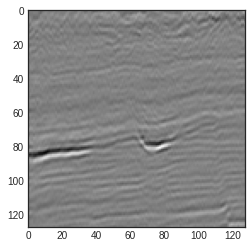

In [ ]:
#@title load 128 test patches
import pickle
from matplotlib import pyplot as plt

def get_samples_hand_crop(path):
    with open(path, 'rb') as handle:
        data_set = pickle.load(handle)  
    return data_set['X_set']


def standardizer(tr):
    ''' Standardize amplitudes within the image '''
    std_func = lambda x: (x - np.mean(x)) / np.std(x)
    tr_std = std_func(tr)
    # tr_std[tr_std > 1] = 1
    # tr_std[tr_std < -1] = -1
    return tr_std


def scale_min_max(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x    


DATA_PATH = '/content/drive/My Drive/Faults/data/Lapteva_faults128x128(1469).pickle'

target_traces = get_samples_hand_crop(DATA_PATH)

to_show = scale_min_max(target_traces[0])

plt.imshow(to_show, cmap='gray')

target_traces.shape, to_show.min(), to_show.max()

In [4]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')

In [ ]:
from obspy.io.segy.core import _read_segy as read_segy
from obspy.io.segy.segy import _read_segy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
import datetime, os

image_sgy_stream = read_segy('/content/drive/My Drive/Faults/preprocess/sgyprocess/F3_entire.sgy')
image_sgy = np.stack(t.data for t in image_sgy_stream.traces)

data_sgy = np.zeros((651 * 951, 462))
data_sgy.shape

extend_count = data_sgy.shape[0] - image_sgy.shape[0]
extend_count

data_sgy[:image_sgy.shape[0], :] = image_sgy

data_sgy = np.array(data_sgy).reshape(651, 951, 462)
data_sgy_reshaped = data_sgy
data_sgy.shape

data_sgy = data_sgy[:500, :, 250:]
data_sgy.shape

In [ ]:
SliceViewer(data_sgy, data_sgy, figsize=(8, 8), tr_cmap='gray', lb_cmap='seismic')

In [ ]:
!rm -rf /content/dataset

In [ ]:
import os
  
SyntheticSeisGen('/content/dataset', 512, data_sgy, data_sgy, patch_size=128)
len(os.listdir('/content/dataset/labels'))

In [ ]:
!rm -rf /content/dataset/labels

In [ ]:
!zip -r -qq '/content/dataset.zip' '/content/dataset/'
!cp -r '/content/dataset.zip' '/content/drive/My Drive/Faults/data/synt/dataset_model_fda512.zip'

In [6]:
!cp -r '/content/drive/My Drive/Faults/data/synt/dataset_model_fda512.zip' ./
!unzip -qq '/content/dataset_model_fda512.zip'

In [14]:
tr = np.fromfile('/content/dataset/traces/10.dat', dtype=np.single)
lb = np.fromfile('/content/dataset/labels/10.dat', dtype=np.single)
tr = np.reshape(tr, (128, 128, 128))
lb = np.reshape(lb, (128, 128, 128))

tr.shape, lb.shape

((128, 128, 128), (128, 128, 128))

In [ ]:
tr = np.fromfile('/content/dataset/seis/0.dat', dtype=np.single)
lb = np.fromfile('/content/dataset/fault/0.dat', dtype=np.single)
tr = np.reshape(tr, (128, 128, 128))
lb = np.reshape(lb, (128, 128, 128))

tr.shape, lb.shape

(0.35077792, 0.66375786)

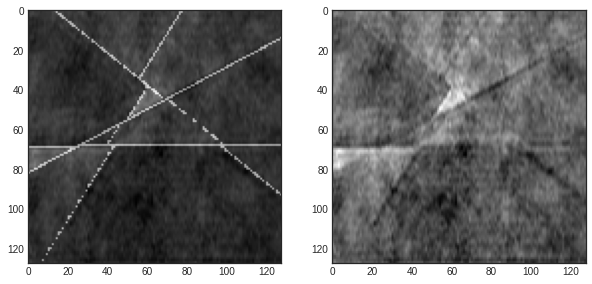

In [15]:
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
i = 20
axs[0].imshow(tr[:, :, i].T, cmap='gray')
axs[0].imshow(lb[:, :, i].T, cmap='gray', alpha=0.5)
axs[1].imshow(tr[:, :, i].T, cmap='gray')
tr[:, :, i].T.min(), tr[:, :, i].T.max()

(0.09534185, 0.8905433)

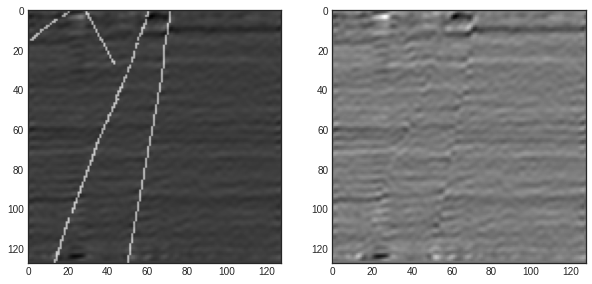

In [16]:
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
i = 80
axs[0].imshow(tr[i].T, cmap='gray')
axs[0].imshow(lb[i].T, cmap='gray', alpha=0.5)
axs[1].imshow(tr[i].T, cmap='gray')
tr[i].T.min(), tr[i].T.max()

(0.2670709, 0.6928829)

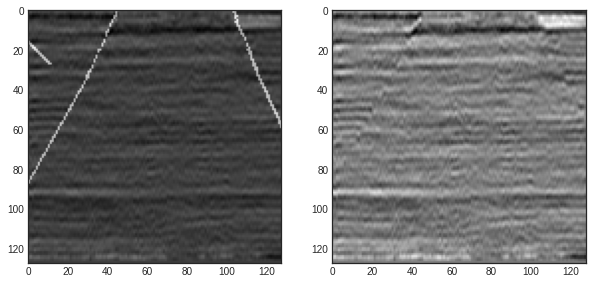

In [18]:
import matplotlib.pyplot as plt
import cv2

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
i = 80
axs[0].imshow(tr[:, i, :].T, cmap='gray')
axs[0].imshow(lb[:, i, :].T, cmap='gray', alpha=0.5)
axs[1].imshow(tr[:, i, :].T, cmap='gray')
tr[:, i, :].T.min(), tr[:, i, :].T.max()

In [12]:
#@title slice viewer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from ipywidgets.widgets import *
from ipywidgets import widgets
from IPython.display import display

plt.style.use('seaborn-white')



class SliceViewer():

    '''
        Arguments: 
            traces_volume - np.array with shape (nx, ny, nz)
            labels_volume - np.array with shape (nx, ny, nz)
            figsize - tuple, plot size

    '''

    def __init__(self, traces_volume, labels_volume,
                 figsize=(7, 7), tr_cmap='gray', lb_cmap='Greens'):

        assert traces_volume.shape == labels_volume.shape, 'Shapes must be equal'

        self.tr_volume = traces_volume
        self.lb_volume = labels_volume
        self.figsize = figsize
        self.tr_cmap = tr_cmap
        self.lb_cmap = lb_cmap

        self.nx, self.ny, self.nz = self.tr_volume.shape

        self.widget = self.__create_widget()


    def __create_widget(self):

        x_slider = IntSlider(min=0, max=self.nx - 1, step=1, value=int(self.nx/2))
        y_slider = IntSlider(min=0, max=self.ny - 1, step=1, value=int(self.ny/2))
        z_slider = IntSlider(min=0, max=self.nz - 1, step=1, value=int(self.nz/2))
        alpha = IntSlider(min=0, max=100, step=5, value=70)
        selector = ['x','y','z']
        w = interact(self.__show, x=x_slider, y=y_slider,
                     z=z_slider, alpha=alpha, dim=selector)

        return w

    
    def __get_slice(self, x, y, z, dim):

        if dim == 'x':
            tr = self.tr_volume[x, :, :]
            lb = self.lb_volume[x, :, :]
        elif dim == 'y':
            tr = self.tr_volume[:, y, :]
            lb = self.lb_volume[:, y, :]
        else:
            tr = self.tr_volume[:, :, z]
            lb = self.lb_volume[:, :, z]
        
        return tr, lb


    def __set_labels(self, ax, dim):

        if dim == 'x':
            ax.set_xlabel('y')
            ax.set_ylabel('z')
        elif dim == 'y':
            ax.set_xlabel('x')
            ax.set_ylabel('z')
        else:
            ax.set_xlabel('y')
            ax.set_ylabel('x')

    
    def __show(self, x, y, z, alpha, dim):

        tr, lb = self.__get_slice(x, y, z, dim)

        fig, ax = plt.subplots(figsize=self.figsize)
        plt.imshow(tr.T, cmap=self.tr_cmap, aspect='equal')
        plt.imshow(lb.T, alpha=(100-alpha)/100, aspect='equal', cmap=self.lb_cmap)
        self.__set_labels(ax, dim)
        # plt.grid()
        plt.show()
        display()

        ax.set_xlabel('x')
        ax.set_ylabel('z')

In [19]:
SliceViewer(tr, lb, figsize=(5, 5), tr_cmap='gray', lb_cmap='seismic')

interactive(children=(IntSlider(value=64, description='x', max=127), IntSlider(value=64, description='y', max=…

In [ ]:
!pip install ipyvolume 

In [ ]:
!pip install plotly